In [ ]:
# the images are stored in google drive, we need to mount it to access the data.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# to get rid of nn.Upsample error (interplolate dafault behavior)
!pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 42.5MB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [ ]:
from fastai import *
from fastai.vision import *
from pathlib import Path

In [ ]:
# path to parent folder
data_path = '/content/drive/My Drive/Random Subset'

# Getting data for all 6 classes and training

In [ ]:
classes = ['Bacterial Pneumonia','COVID-19','Normal','Other Findings','TB','Viral Pneumonia']

In [ ]:
# getting the image file names from each folder (category)

total = 0
for cls in classes:
  path = data_path + '/' + cls
  fnames = get_image_files(path)
  print("We have", len(fnames),"CXR images of type", cls)
  total+= len(fnames)
print("We have",total,"images in total.")

We have 616 CXR images of type Bacterial Pneumonia
We have 288 CXR images of type COVID-19
We have 613 CXR images of type Normal
We have 615 CXR images of type Other Findings
We have 394 CXR images of type TB
We have 616 CXR images of type Viral Pneumonia
We have 3142 images in total.



(Later, we will take care of this by augmenting the data for under-represented classes, and decreasing the number of images of over-represented classes.)

In [ ]:
# creating the ImagedataBunch
np.random.seed(42)
data = ImageDataBunch.from_folder(data_path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Bacterial Pneumonia',
  'COVID-19',
  'Normal',
  'Other Findings',
  'TB',
  'Viral Pneumonia'],
 6,
 2514,
 628)

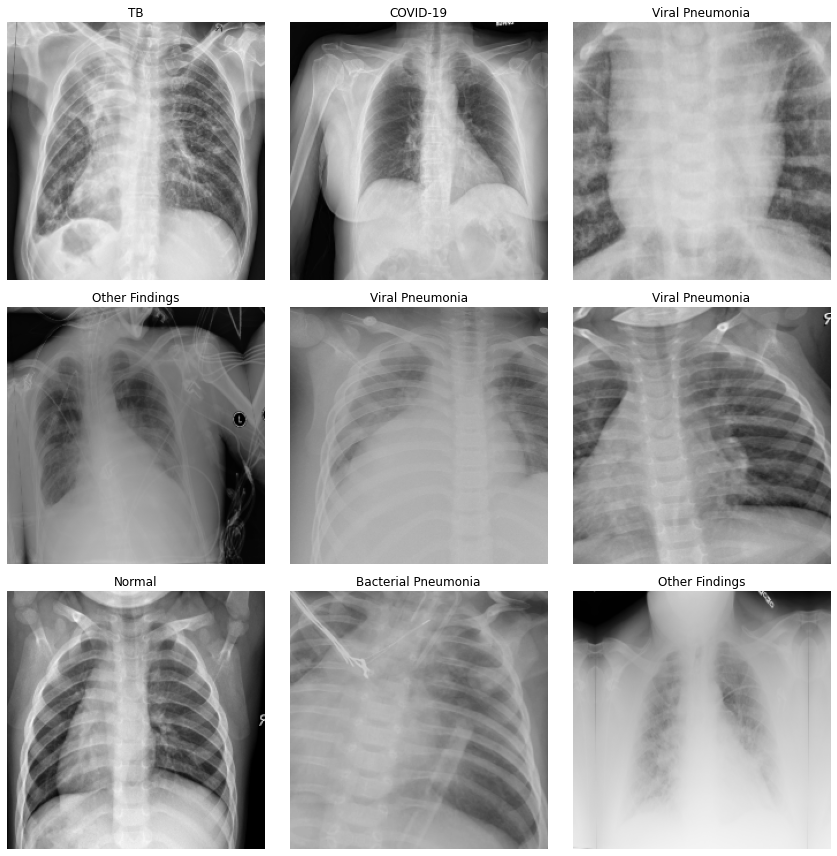

In [ ]:
data.show_batch(rows=3, figsize=(12,12))

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics = [accuracy, error_rate])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.397551,0.967099,0.716560,0.283439,10:07
1,0.990396,0.662225,0.765924,0.234076,03:38
2,0.787333,0.564793,0.781847,0.218153,03:37
3,0.660789,0.533343,0.799363,0.200637,03:35


'error_rate' has not yet started increasing erratically. Also, training loss is still more than validation loss. Hence, we are not overfitting yet.

Lets see the images where our learner had the highest loss.

In [ ]:
interp1 = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp1.top_losses()

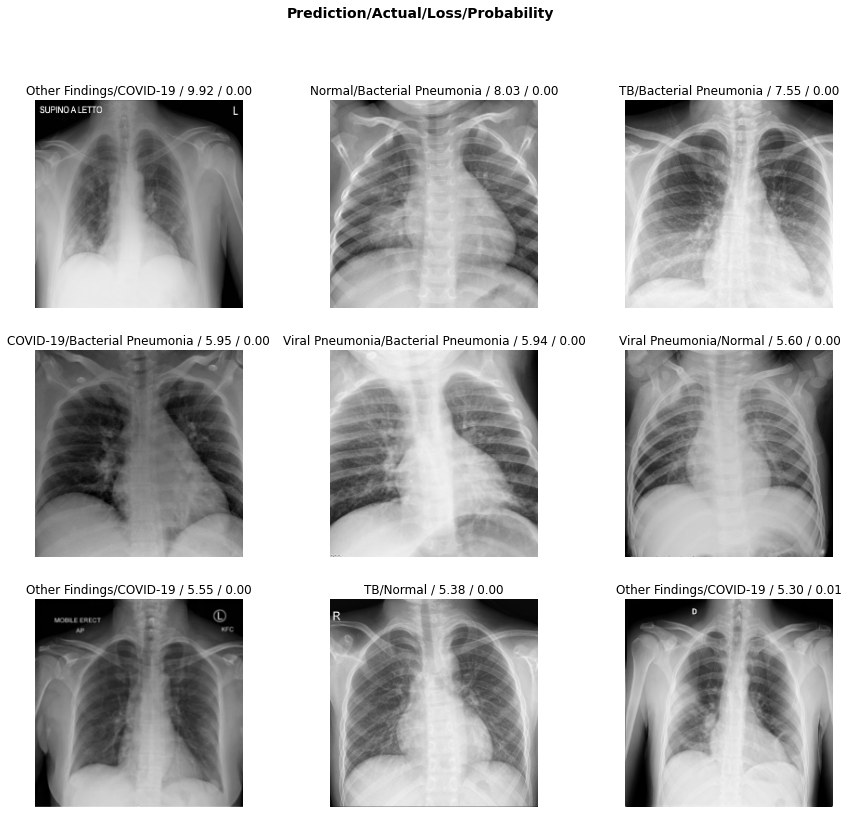

In [ ]:
interp1.plot_top_losses(9, figsize=(15,13))

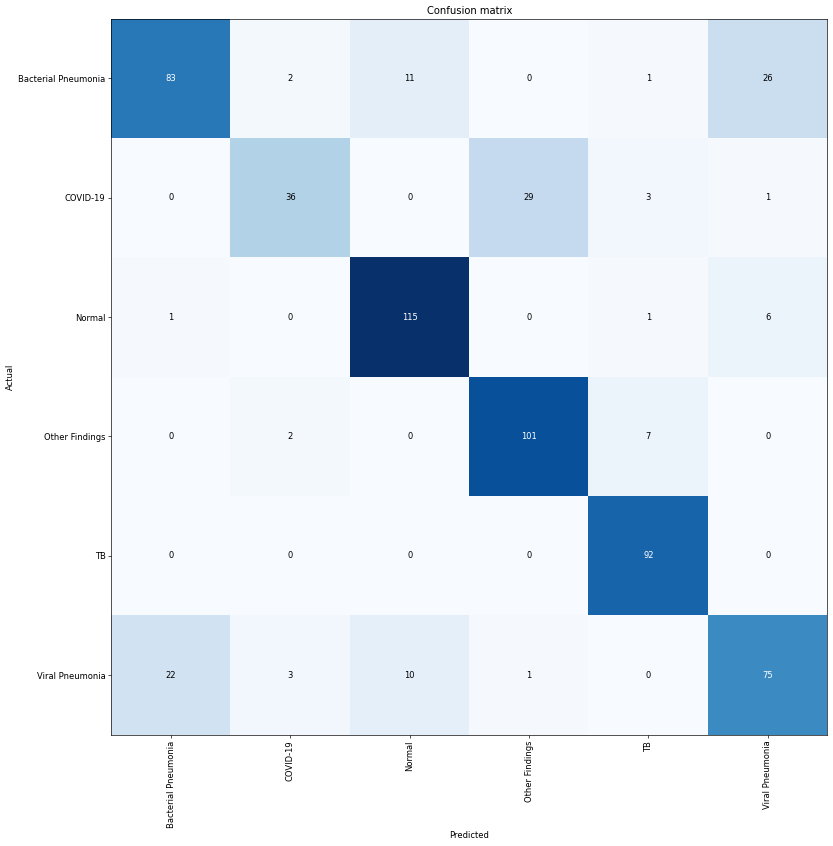

In [ ]:
interp1.plot_confusion_matrix(figsize=(14,14), dpi=60)

Our learner seems to be the most confused while classifying CXR images of pneumonia. About half of the Viral Pneumonia images are classified as Bacterial Pneumonia.

We can somewhat understand why the leaner is making so many mistakes. On a broad level, these images all belong to a single category - "X-Ray". There are very subtle differences in the images that distinguish one disease from the other. This diagnosis is done by doctors and specialists who possess extensive domain knowledge. We are doing fine-grained classification here. 

Nevertheless, we will try to find ways to improve the accuracy of our model.

In [ ]:
interp1.most_confused(min_val=2)

[('COVID-19', 'Other Findings', 29),
 ('Bacterial Pneumonia', 'Viral Pneumonia', 26),
 ('Viral Pneumonia', 'Bacterial Pneumonia', 22),
 ('Bacterial Pneumonia', 'Normal', 11),
 ('Viral Pneumonia', 'Normal', 10),
 ('Other Findings', 'TB', 7),
 ('Normal', 'Viral Pneumonia', 6),
 ('COVID-19', 'TB', 3),
 ('Viral Pneumonia', 'COVID-19', 3),
 ('Bacterial Pneumonia', 'COVID-19', 2),
 ('Other Findings', 'COVID-19', 2)]

Classifying a diseased image as Normal, is more dangerous than classifying normal as diseased. 

If a normal person is classified as diseased, we can verify if its true just by doing another test. But if an unhealthy person is classified as Normal, this can be disastrous. The disease of the person will go untreated.

Hence, we should try to improve the recall in detecting disease, rather than precision.

In this case, Type 2 errors in clasification are more costly.

In [ ]:
# saving the model locally
learn.export("stage-1.pkl")

In [ ]:
learn.save('stage-1')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


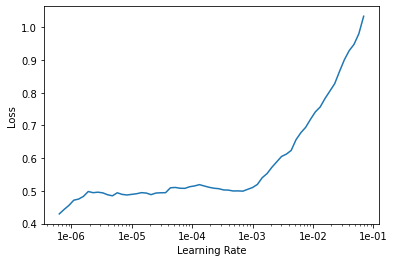

In [ ]:
learn.recorder.plot()

There is no region of steep descent in the curve.

In [ ]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.524212,0.543582,0.820064,0.179936,03:34
1,0.463744,0.466108,0.835987,0.164013,03:32
2,0.421807,0.416512,0.856688,0.143312,03:32


After training for 4 + 3 = 7 epochs, we have achieved an accuracy of 85%. This is good. Because the images are very similar, and our model is right 85 out of 100 times in classifying the disease.

And we have used only s small set of 3000 images.

In [ ]:
learn.save('1-8-20 4cycles 6classes stage 2')

In [ ]:
learn.export("subset-stage-2.pkl")

:ets try to test our learner by predicting the class of a few images. I will manually upload the images to drive, and predict usng learner.

In [ ]:
# loading the exported learner
learn = load_learner(data_path, 'subset-stage-2.pkl')

In [ ]:
defaults.device = torch.device('cpu')

In [ ]:
img = open_image('/content/drive/My Drive/Random Subset/CHNCXR_0525_1.png')
img
# true class is "TB"

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


'TB'

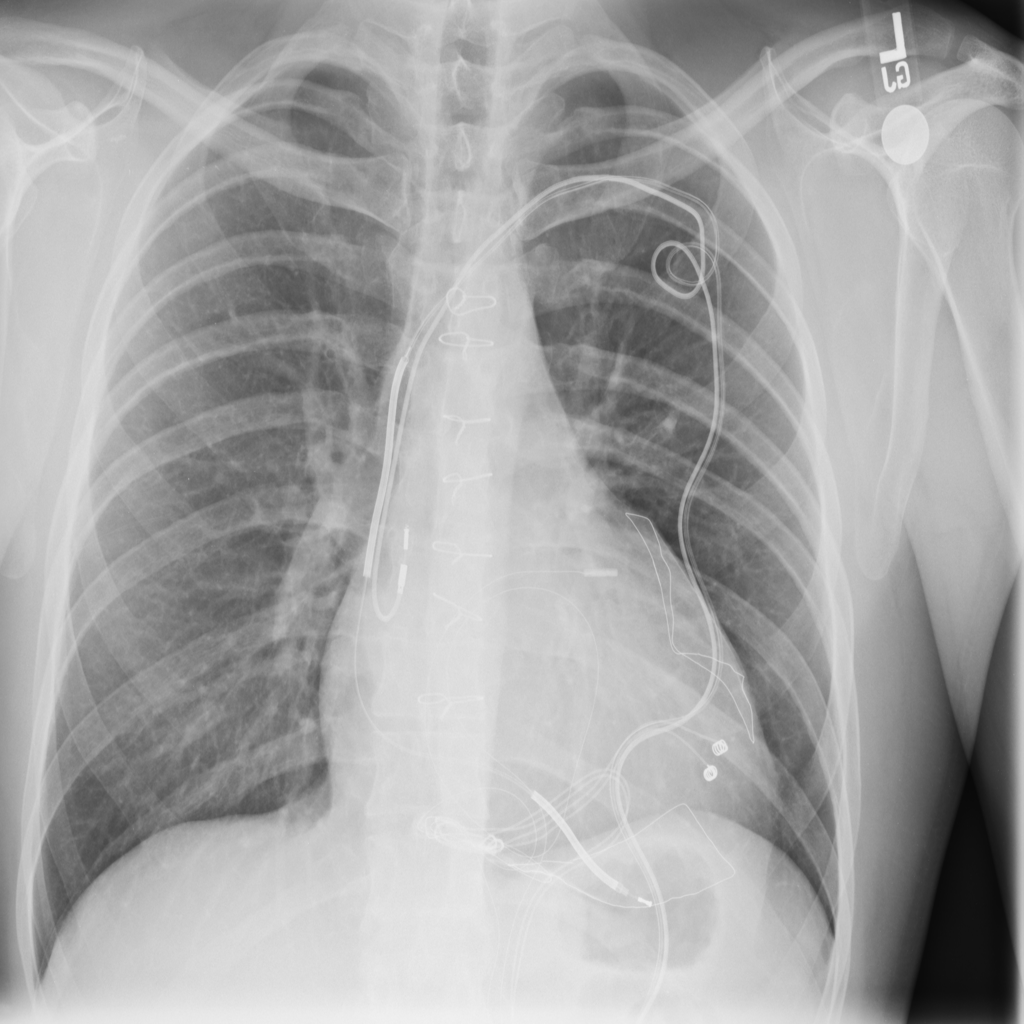

In [ ]:
img = open_image('/content/drive/My Drive/Random Subset/00000521_000.png')
img
# true class is "Other Findings"

In [ ]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class.obj

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


'Other Findings'

# Training with Images of 64 X 64

In [ ]:
# using images of size 64 X 64
path = data_path
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(size=64)
        .databunch())                 

In [ ]:
data.classes

['Bacterial Pneumonia',
 'COVID-19',
 'Normal',
 'Other Findings',
 'Random Subset',
 'TB',
 'Viral Pneumonia']

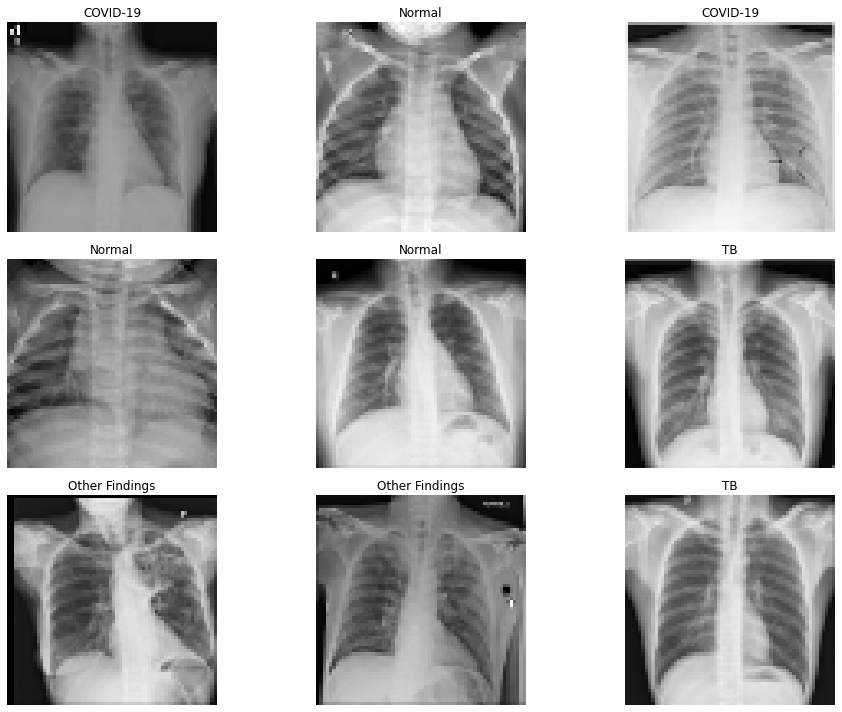

In [ ]:
data.show_batch(rows = 3, figsize = (14,10))

In [ ]:
f_score = partial(fbeta, thresh = 0.2)

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics = accuracy)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


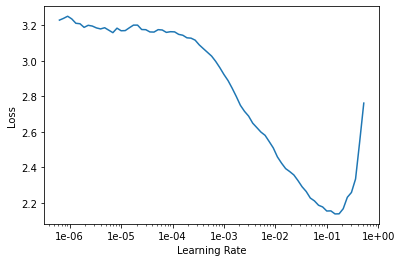

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 0.001

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.317661,1.524154,0.523885,03:51
1,1.513407,1.022265,0.665605,02:19
2,1.112880,0.767682,0.702229,02:15
3,0.865325,0.742865,0.726115,02:12
4,0.748434,0.744711,0.730892,02:11


In [ ]:
learn.save('new_stage-1-size-64')

In [ ]:
learn.export("new_stage-1-size-64.pkl")

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


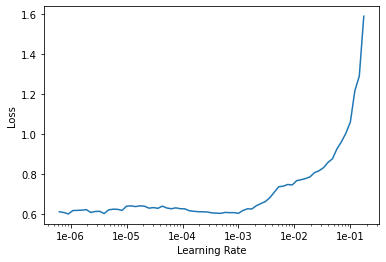

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(5e-5, lr/2))

epoch,train_loss,valid_loss,accuracy,time
0,0.608370,0.606352,0.781847,02:16
1,0.482793,0.565122,0.799363,02:14
2,0.350067,0.609955,0.816879,02:13
3,0.215173,0.516967,0.839172,02:14
4,0.133340,0.502570,0.845541,02:17


In [ ]:
learn.export("unfreeze-stage-1-size-64.pkl")
learn.save('unfreeze-stage-1-size-64')

Now we will create a new databunch of image size 128 by 128, and train the same learner using transfer learning.

# Training with images of 128 X 128

In [ ]:
# using images of size 128 X 128
path = data_path
data_2 = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder()
        .transform(size=128)
        .databunch())   

In [ ]:
learn.data = data_2

In [ ]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


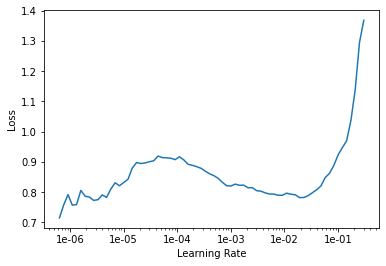

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 0.001

0.001

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.777712,0.560995,0.821656,02:29
1,0.628239,0.443297,0.835987,02:28
2,0.490273,0.432373,0.837580,02:24
3,0.405591,0.416886,0.837580,02:26
4,0.346249,0.416776,0.839172,02:29


Accuracy seems to be stagnant, validation loss is more than training loss.

In [ ]:
learn.export("stage-2-size-128.pkl")
learn.save('stage-2-size-128')

In [ ]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


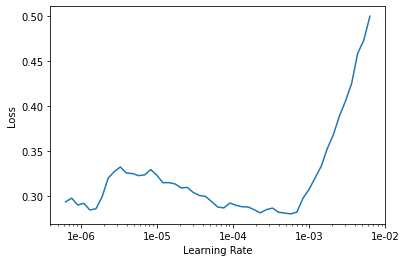

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(5e-5, lr/4))

epoch,train_loss,valid_loss,accuracy,time
0,0.317811,0.413152,0.853503,02:32
1,0.235875,0.386799,0.861465,02:33
2,0.179713,0.430592,0.869427,02:36
3,0.101160,0.366705,0.890127,02:33
4,0.056134,0.368156,0.898089,02:36


We are getting close to 90% accuracy, but at the cost of overfitting. The training loss is much lower than val loss. Although the validation loss is a its lowest.

In [ ]:
learn.export("unfreeze-stage-2-size-128.pkl")
learn.save('unfreeze-stage-2-size-128')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
losses,idxs = interp.top_losses()

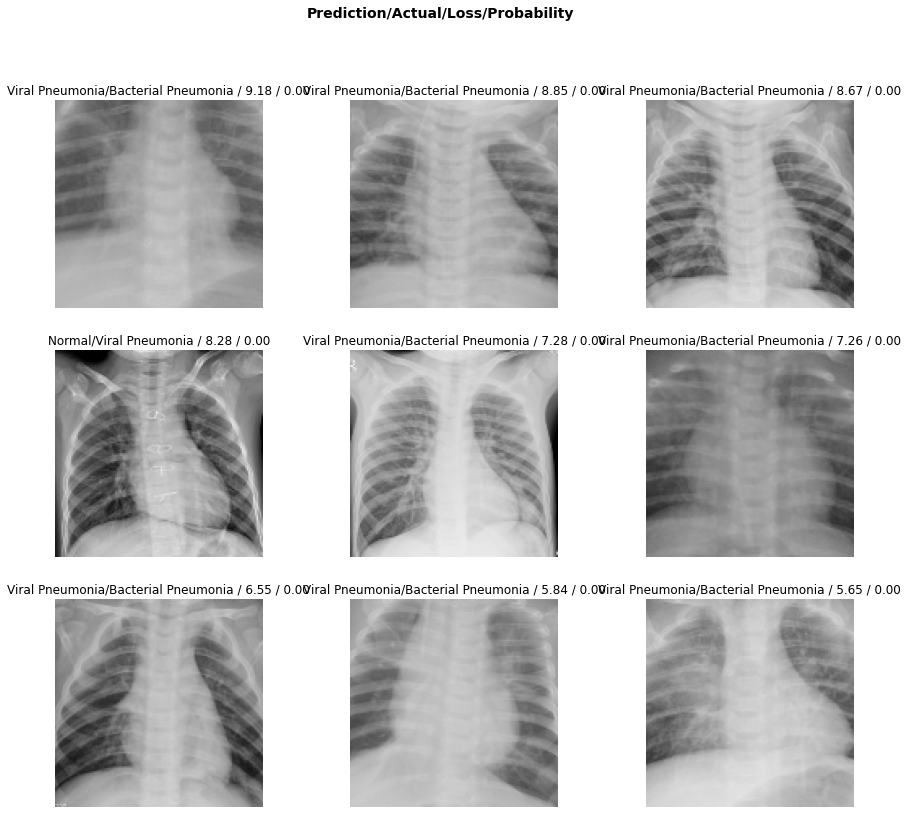

In [ ]:
interp.plot_top_losses(9, figsize=(15,13))

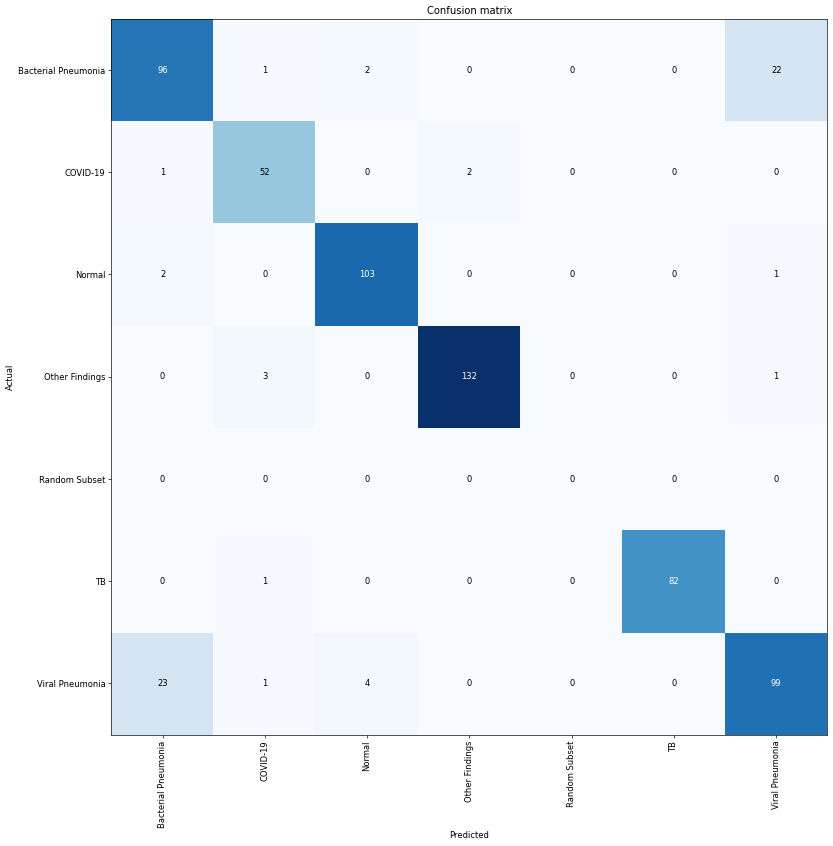

In [ ]:
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)

As we had noticed earlier, our learner is most confused between bacterial and viral pneumonia. From a real-world scenario, this seems acceptable, because CXRs of both types of pneumonia may look very similar. Moreover, we are using low resolution images in a situation where final labelling is based on very minute details in the images. Thus, our classifier is performing reasonably.